In [1]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

print('pandas')
import pandas as pd 
print('numpy')
import numpy as np 
print('matplotlib')
from matplotlib import pyplot as plt 
print('sbn')
import seaborn as sbn 
print('os/sys')
import os, sys
print('simpleitk')
import SimpleITK as sitk

print('here')
# scripts found in ./workflow/libs
sys.path.append('./workflow/libs/')
%aimport utils
%aimport config
%aimport segment 
%aimport match 
%aimport missingness 
%aimport register 
%aimport evaluate 
%aimport qc 

pandas
numpy
matplotlib
sbn
os/sys
simpleitk
here
CPU times: user 1.21 s, sys: 941 ms, total: 2.15 s
Wall time: 8.9 s


# Overview 

In [2]:
img_file_names = os.listdir(config.image_dir_path)
parsed_names = pd.DataFrame([utils.parse_file_name(x) for x in img_file_names])
parsed_names.head()

,round,protein,slide_name,date,scan_id,scene,color_channel,note,file_type,original
0,R2,PCNA.AR.ER.GATA3,S3,2020-01-23,13492,Scene-2,c4,ORG,tif,R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...
1,R1,H3K27me3.CCNB1.CCND1.Ki67,S3,2020-01-22,13485,Scene-1,c3,ORG,tif,R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...
2,R1,H3K27me3.CCNB1.CCND1.Ki67,S3,2020-01-22,13485,Scene3,c2,ORG,tif,R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...
3,R1,H3K27me3.CCNB1.CCND1.Ki67,S3,2020-01-22,13485,Scene-1,c5,ORG,tif,R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...
4,R2,PCNA.AR.ER.GATA3,S3,2020-01-23,13492,Scene-2,c3,ORG,tif,R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...


# Choose slide, scene

In [3]:
slides = parsed_names.slide_name.unique()
_ = [print(f'{i} : {x}') for i,x in enumerate(slides)]
print()
slide_in = input('please choose the slide to use [use integer]:  ')
slide_choice = slides[int(slide_in)]
print('slide name selected:', slide_choice)

parsed_names2 = parsed_names[parsed_names.slide_name == slide_choice]
print('meta dataframe shape', parsed_names2.shape)

0 : S3

please choose the slide to use [use integer]:  0
slide name selected: S3
meta dataframe shape (45, 10)


In [4]:
scenes = parsed_names2.scene.unique()

_ = [print(f'{i} : {x}') for i,x in enumerate(scenes)]
print()
scene_in = input('please choose the scene to use [use integer]:  ')
scene_choice = scenes[int(scene_in)]
print('slide name selected:', scene_choice)

parsed_names3 = parsed_names2[parsed_names2.scene == scene_choice]
print('meta dataframe shape', parsed_names3.shape)

0 : Scene-2
1 : Scene-1
2 : Scene3
3 : Scene-3

please choose the scene to use [use integer]:  1
slide name selected: Scene-1
meta dataframe shape (15, 10)


# Load images 

This can take a few minutes, grab a cup of tea. 

In [5]:
%%time
imgs = {}
i = 1
for path in parsed_names3.original.values: 
    print(f'progress: {i}/{parsed_names3.original.values.shape[0]}', end='\r')
    imgs[path] = sitk.ReadImage(config.image_dir_path + path)
    i+=1

CPU times: user 5 s, sys: 21.1 s, total: 26.1 s
Wall time: 47.8 s


# Segment R0 cores 

we'll down-sample our images to speed up the processing. 

shape of downsampled R0: (2044, 2040)


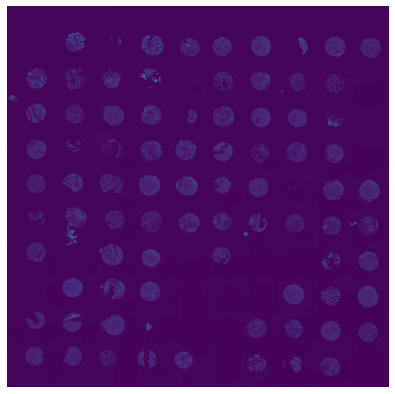

In [6]:
R0_dapi_name = parsed_names3[(parsed_names3.color_channel == 'c1') & (parsed_names3['round'] == 'R0')]

R0_dapi_full = imgs[R0_dapi_name.original.item()]
R0_dapi = R0_dapi_full[::config.downsample_proportion,::config.downsample_proportion]

print('shape of downsampled R0:', R0_dapi.GetSize())

utils.myshow(R0_dapi)

rescaling img..
applying gaussing blur...


<Figure size 432x288 with 0 Axes>

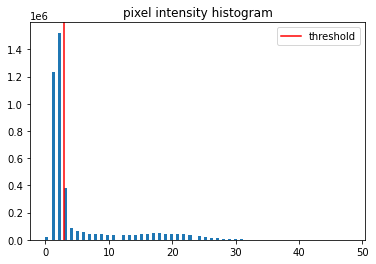

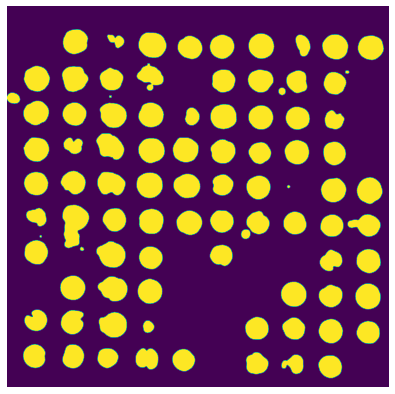

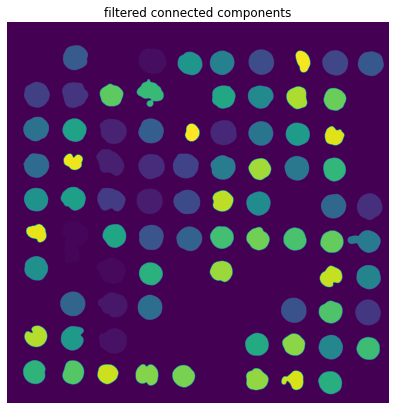

CPU times: user 3.39 s, sys: 136 ms, total: 3.53 s
Wall time: 3.62 s


,center_x,center_y,width,height,Volume (nm^3),Elongation,Flatness,Oriented Bounding Box Minimum Size(nm),Oriented Bounding Box Maximum Size(nm),Intensity Mean,Intensity Standard Deviation,Intensity Skewness,component
1,296,1065,143,231,0.945760,1.897392,1.897392,0.936080,1.523790,16.939468,23.038116,2.398662,1
2,478,1260,156,141,0.685206,1.149013,1.149013,0.888309,1.039794,17.505488,15.831725,1.004443,2
3,704,142,149,135,0.678446,1.115321,1.115321,0.886789,0.975430,18.107797,20.897464,1.620785,3
4,492,1639,149,136,0.658462,1.129022,1.129022,0.887439,0.976184,17.412705,15.841921,1.167412,4
5,486,1448,159,133,0.649801,1.223383,1.223383,0.845200,1.043358,15.951495,19.522191,2.419621,5


In [7]:
%%time
R0_dapi_stats, shape_stats = segment.segment_dapi_round(R0_dapi, plot=True)
R0_dapi_stats.head()

# generate core id mapping 

use the `out` argument to specify the output directory where the image should be saved. 

Make sure that you use downsampled R0-c1 (dapi) image and only the R0-c1 (dapi) stats. 

saving to: /home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1
plotting


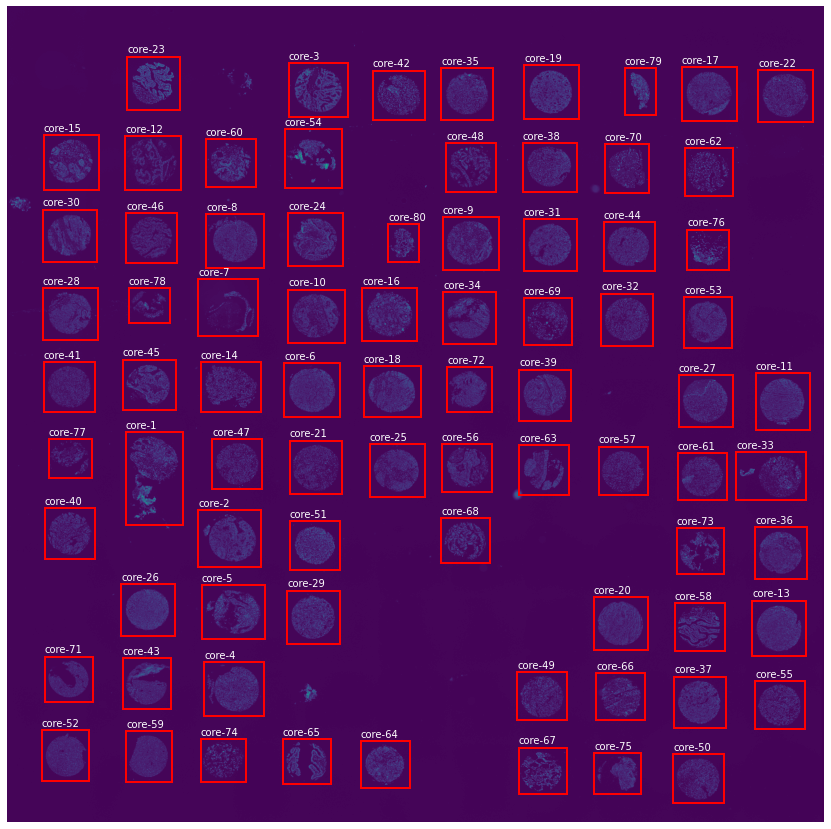

In [75]:
segment.generate_core_id_map(R0_dapi, R0_dapi_stats, plot=True, out='/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1') 

# Choose core 

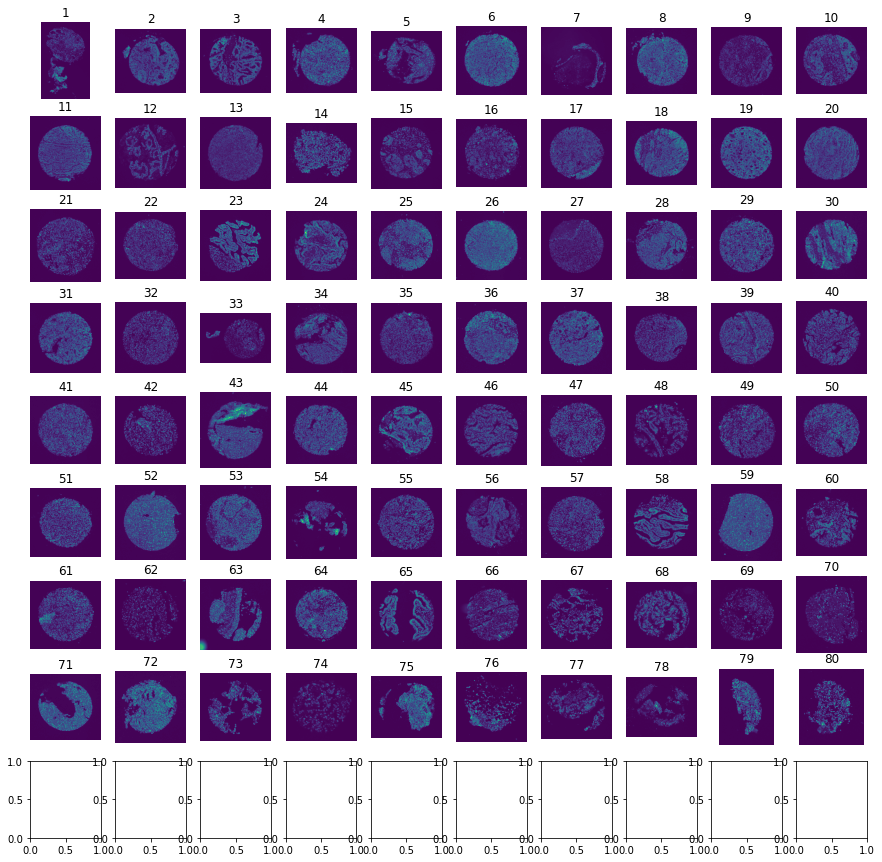

In [8]:
segment.plot_cores(R0_dapi, R0_dapi_stats)

which core would you like to use? (integer):  5
you chose:  5


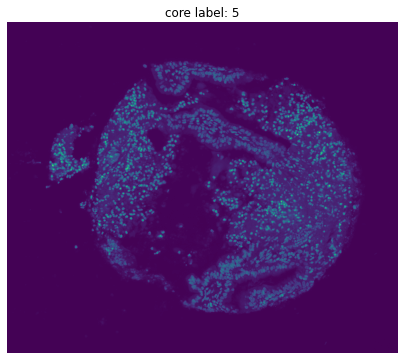

In [9]:
core_in = int(input('which core would you like to use? (integer):  '))
print('you chose: ', core_in)

R0_dapi_core = segment.select_core(R0_dapi_full, core_in, R0_dapi_stats, scale=config.downsample_proportion)

utils.myshow(R0_dapi_core, f'core label: {core_in}')

# match core labels across rounds 

In [79]:
%%time

res = match.get_all_rounds_core_statistics(parsed_names3, imgs, verbose=True)

processing:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif
processing:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
processing:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
CPU times: user 6.6 s, sys: 497 ms, total: 7.1 s
Wall time: 804 ms


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c3_ORG.tif
plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c5_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif
plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c2_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c4_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c5_ORG.tif
plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c4_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c3_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c5_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c4_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c3_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1

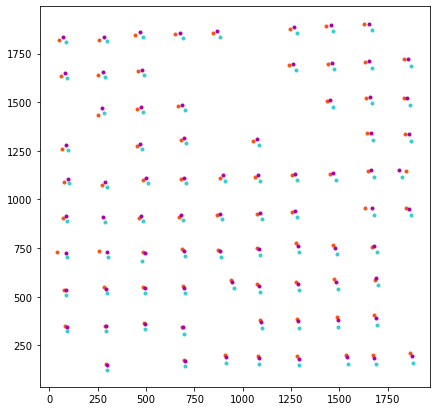

In [50]:
plt.figure(figsize=(7,7))

for i, name in enumerate(parsed_names3.original.values):
    print('plotting centers: ', name)
    rgb = np.random.rand(3)
    temp = res[res.img_name == name]
    plt.plot(temp.center_x, temp.center_y, c=rgb, marker='.', linestyle='None')
    
plt.show()

In [51]:
R0_nclus = res[lambda x: x['round']=='R0'].shape[0]
R1_nclus = res[lambda x: x['round']=='R1'].shape[0]
R2_nclus = res[lambda x: x['round']=='R2'].shape[0]

print('number of clusters in each round:', (R0_nclus, R1_nclus, R2_nclus))

number of clusters in each round: (80, 80, 79)


In [52]:
cluster_labels = match.match_cores_across_rounds(res)
res = res.assign(cluster = cluster_labels)

using clustering method: dbscan


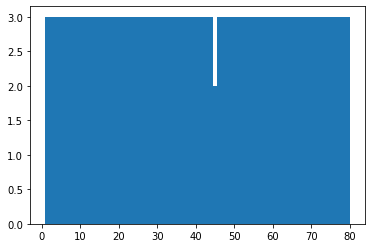

clusters with missing cores: [46]


In [53]:
plt.figure()
plt.hist(cluster_labels, bins=len(np.unique(cluster_labels)))
plt.show()

num_of_rounds = parsed_names['round'].unique().shape[0]

uniq, labels = np.unique(cluster_labels + 1, return_counts=True)
print('clusters with missing cores:', np.unique(uniq[labels < num_of_rounds]))

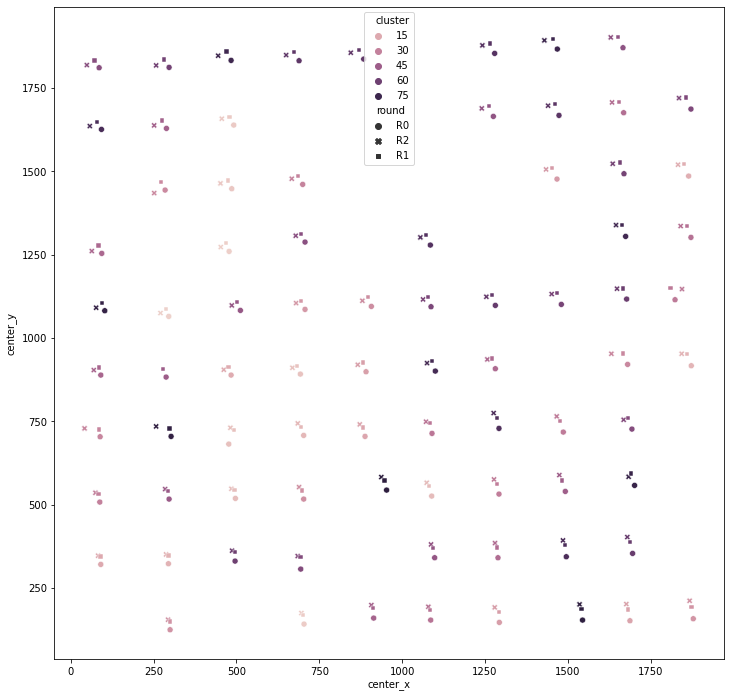

In [54]:
plt.figure(figsize=(12,12))
sbn.scatterplot(x='center_x', y='center_y', hue='cluster', style='round', data=res)
plt.show()

## Inspect the matched data

cluster choice: 5


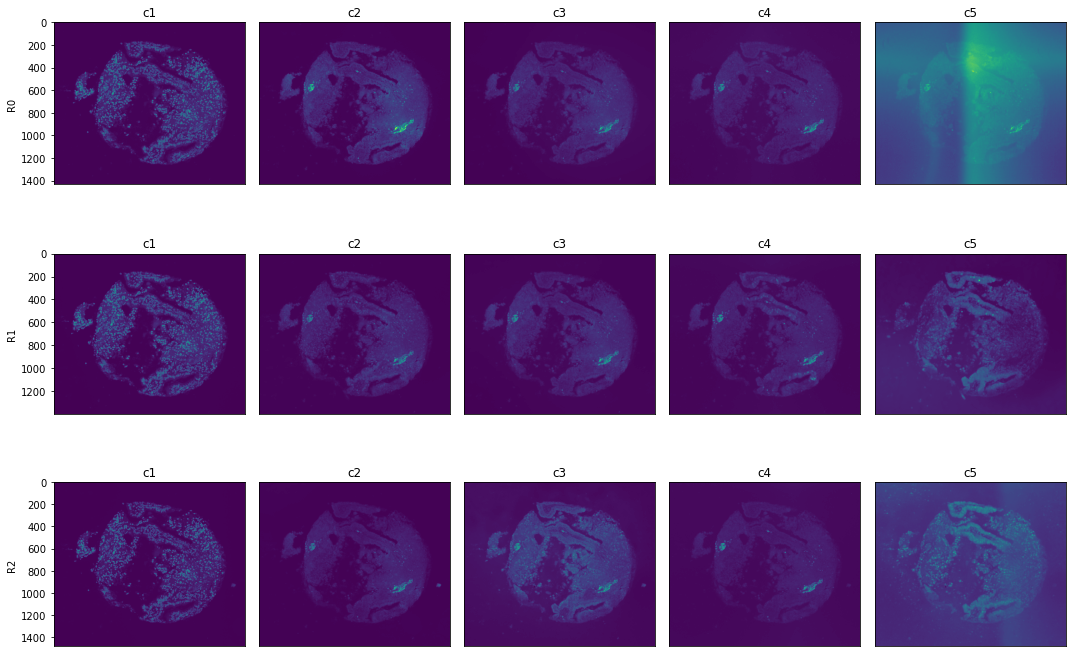

In [16]:
cluster_choice = res[(res['round'] == 'R0') & (res['component'] == core_in)].cluster.item()
print('cluster choice:', cluster_choice)

res_choice = res[res.cluster == cluster_choice]
res_choice.head()

selected_cores = {x:{'unregistered':{}} for x in res_choice['round'].unique()}

f,axes = plt.subplots(num_of_rounds, 5, figsize=(15,10))

for ax,(i, row) in zip(axes.flat, parsed_names3.sort_values(['round', 'color_channel']).reset_index(drop=True).iterrows()): 
    
    print('progress:', i, end='\r')
    temp = res_choice[(res_choice.cluster == cluster_choice) & (res_choice['round'] == row['round'])]
    
    if temp.shape[0] == 0: 
        print('no image')
        continue
        #selected_cores[row['round']]['unregistered'][row.color_channel] = None
        #continue
        
    _core = segment.select_core(imgs[row.original], temp.component, temp, scale=config.downsample_proportion)
    
    _core.SetOrigin((0,0))
    
    selected_cores[row['round']]['unregistered'][row.color_channel] = _core
    
    utils.myshow(_core, ax=ax)
    
    ax.set_title(row.color_channel)
    if row.color_channel == 'c1': 
        ax.set_ylabel(row['round'])
        ax.axes.yaxis.set_visible(True)
    
plt.tight_layout()
plt.show()

# Register Dapi Images 


In [17]:
%%time
print('generating registration function...')
for R in selected_cores.keys(): 
    if R == 'R0': continue
    print('#'*20)
    print('ROUND:', R)
    print('#'*20)
        
    selected_cores[R]['reg_Tx'] = register.get_registration_transform(selected_cores['R0']['unregistered']['c1'], 
                                                                      selected_cores[R]['unregistered']['c1'], 
                                                                      verbose=True)

generating registration function...
####################
ROUND: R2
####################
-------
itk::simple::Transform
 TranslationTransform (0x5644f32211a0)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 142463
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [0.0109828, 0.0104402]

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 22 iterations. Gradient magnitude (8.24009e-05) is less than gradient magnitude tolerance (0.0001).
 Iteration: 23
 Metric value: -0.5164726151270729
####################
ROUND: R1
####################
-------
itk::simple::Transform
 TranslationTransform (0x5644f23bb260)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 144081
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [-0.0114041, -0.00602805]

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Gradie

In [18]:
%%time
print('preforming transformation...')
for R in selected_cores.keys(): 
    selected_cores[R]['registered'] = {}
    for c in selected_cores[R]['unregistered'].keys():
        if R == 'R0':
            # for convenience - fixed image
            selected_cores[R]['registered'][c] = selected_cores[R]['unregistered'][c]
        else:
            print('registering:', (R, c))
            # trasformed each channel using the dapi registration 
            selected_cores[R]['registered'][c] = register.preform_transformation(selected_cores['R0']['unregistered']['c1'],
                                                                                     selected_cores[R]['unregistered']['c1'], 
                                                                                     selected_cores[R]['reg_Tx'])



preforming transformation...
registering: ('R2', 'c1')
registering: ('R2', 'c2')
registering: ('R2', 'c3')
registering: ('R2', 'c4')
registering: ('R2', 'c5')
registering: ('R1', 'c1')
registering: ('R1', 'c2')
registering: ('R1', 'c3')
registering: ('R1', 'c4')
registering: ('R1', 'c5')
CPU times: user 729 ms, sys: 36.4 ms, total: 765 ms
Wall time: 100 ms


# Registration visualization 

We will combine the first 3 Dapi Rounds into a single image (round per channel). White indicates overlapping pixel intensities. Any non-white indicates differences in dapi image registrations. 

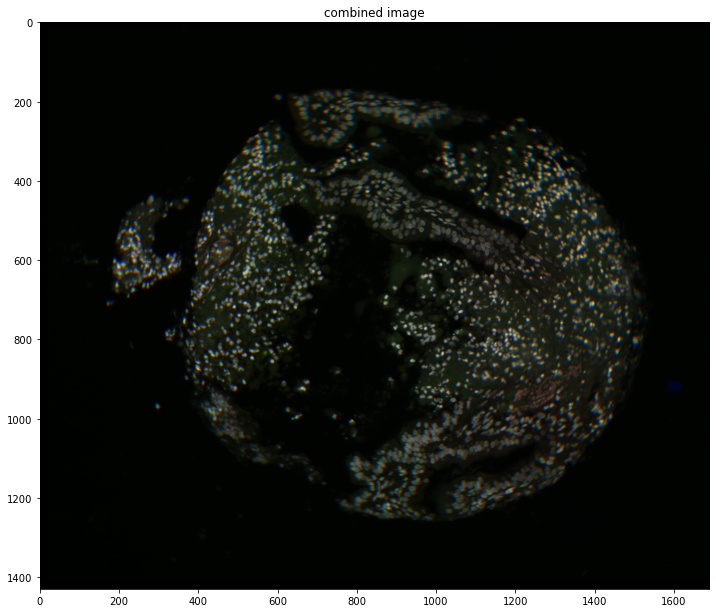

In [19]:
sigm1 = sitk.Cast(sitk.RescaleIntensity(selected_cores['R0']['registered']['c1']), sitk.sitkUInt8)
sigm2 = sitk.Cast(sitk.RescaleIntensity(selected_cores['R1']['registered']['c1']), sitk.sitkUInt8)
sigm3 = sitk.Cast(sitk.RescaleIntensity(selected_cores['R2']['registered']['c1']), sitk.sitkUInt8)

cimg = sitk.Compose(sigm1, sigm2, sigm3)

plt.figure(figsize=(12,12))
plt.title('combined image')
plt.imshow(sitk.GetArrayViewFromImage(cimg)) 
plt.show()

# Zoom in for better clarity

Change `wsize` below to change magnification

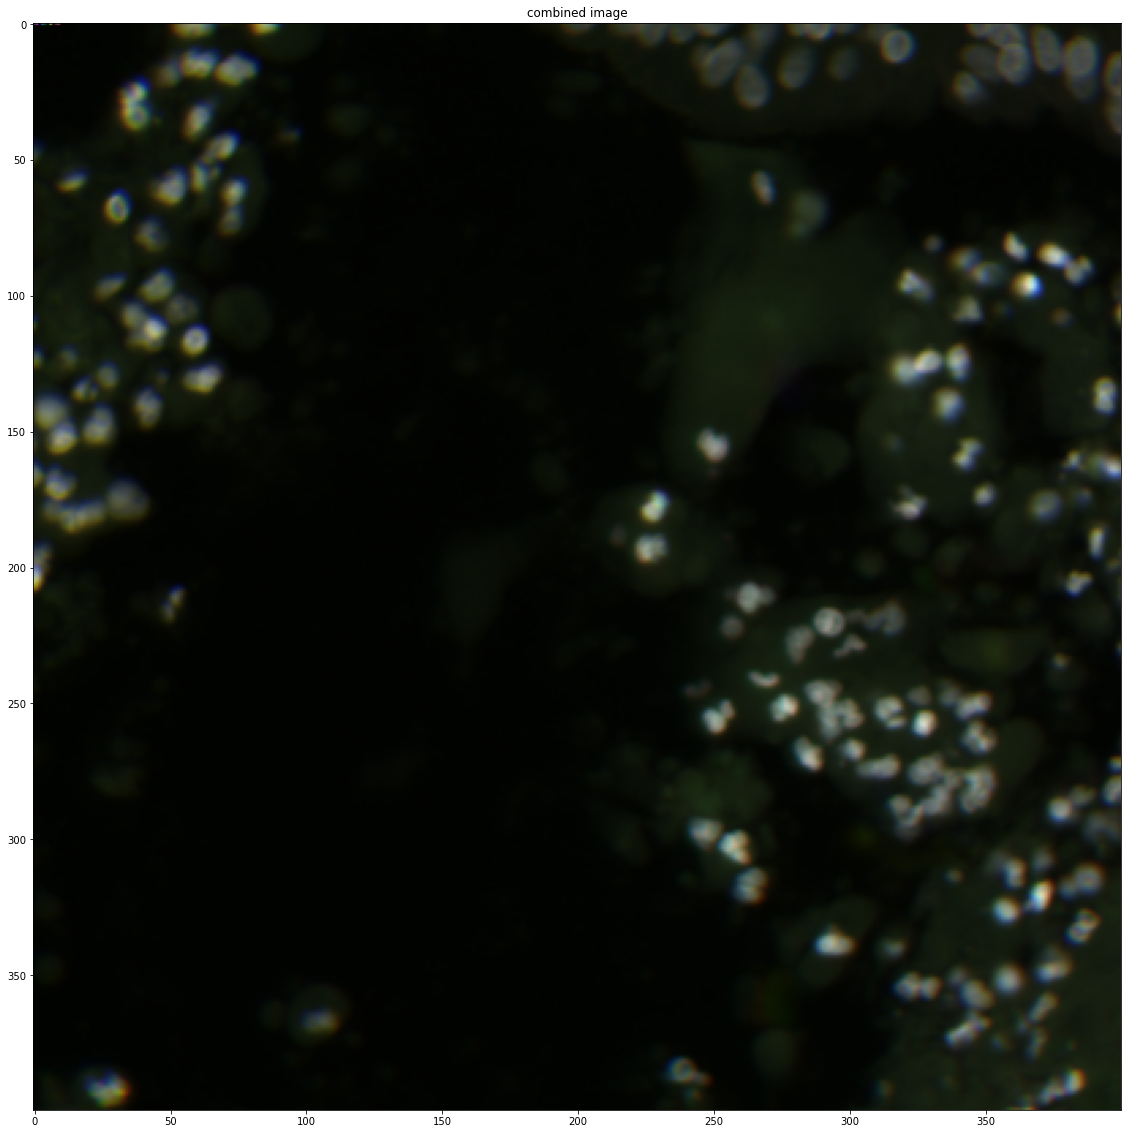

In [20]:
plt.figure(figsize=(20,20))
plt.title('combined image')

wsize = 200
x,y = cimg.GetSize()
plt.imshow(sitk.GetArrayViewFromImage(cimg[int(x/2-wsize):int(x/2+wsize), int(y/2-wsize):int(y/2+wsize)])) 
plt.show()

# Evaluating Registration 

To do this, we will follow the steps below:

1. Apply detailed binary segmentation; ideally we want cell level features 

2. Apply transformation from (1) to each registered DAPI image

3. Compare each subsequent registration mask and calculate success metrics 


## Below is the R0-DAPI image segmentation 

Inspect this, it should have decent cell level features. 

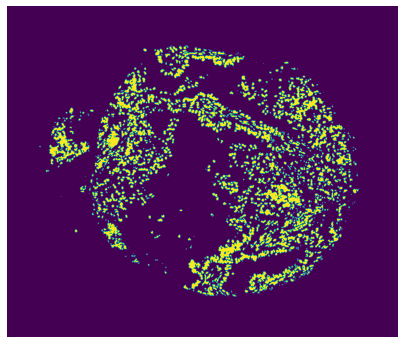

In [21]:
R0_dapi_seg = segment.perform_otsu_threshold(selected_cores['R0']['registered']['c1'])
utils.myshow(R0_dapi_seg)

Round: R0 -> R0
review the segmentations to make sure the look appropriate for comparison...


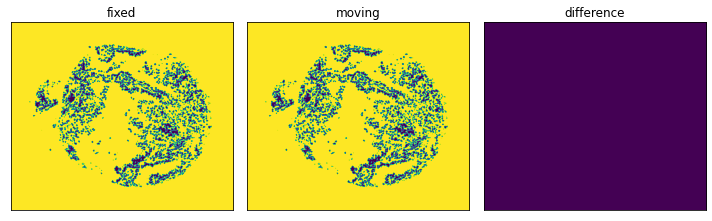

Round: R2 -> R0
review the segmentations to make sure the look appropriate for comparison...


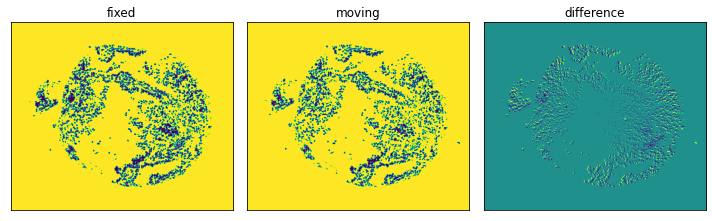

Round: R1 -> R0
review the segmentations to make sure the look appropriate for comparison...


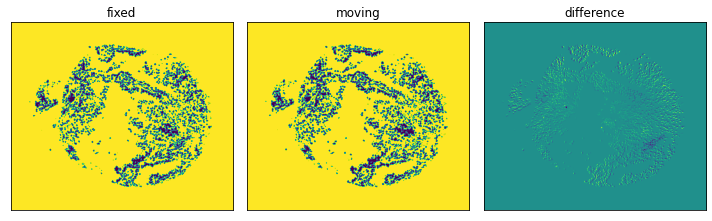

,name,jacaard_coef,dice_coef,volume_similarity,false_neg_err,false_pos_err,hausdorff_dist
0,R0->R0;core-5,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000
1,R2->R0;core-5,0.371908,0.542176,0.14135,0.416592,0.493613,0.085849
2,R1->R0;core-5,0.633501,0.775636,-0.04272,0.240585,0.207435,0.022703


In [22]:
_res = []
for R in selected_cores.keys():
    print(f'Round: {R} -> R0')
    _res.append(evaluate.eval_registration(selected_cores['R0']['registered']['c1'],
                                           selected_cores[R]['registered']['c1'], 
                                           f'{R}->R0;core-{core_in}'))

res = pd.DataFrame(_res, index=range(len(_res)))
res.head()